
# Task 3 — Multimodal ML: Housing Price Prediction (Images + Tabular)

**Objective:** Predict housing prices using both **structured data** and **house images**.

**Skills Gained:** Multimodal ML • CNNs • Feature Fusion • Regression & Evaluation (MAE/RMSE)

> Notebook includes a small **synthetic dataset** under `data/`. 


## Setup 

In [1]:
!python -V
DATA_DIR = r"/mnt/data/Multimodal_Housing_Price_Prediction/data"
CSV_PATH = r"/mnt/data/Multimodal_Housing_Price_Prediction/data/housing_tabular.csv"
IMG_DIR = r"/mnt/data/Multimodal_Housing_Price_Prediction/data/images"
print('CSV:', CSV_PATH)
print('Images folder:', IMG_DIR)


Python 3.11.4
CSV: /mnt/data/Multimodal_Housing_Price_Prediction/data/housing_tabular.csv
Images folder: /mnt/data/Multimodal_Housing_Price_Prediction/data/images


In [3]:
!pip install torch torchvision torchaudio

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/84/57/2f64161769610cf6b1c5ed782bd8a780e18a3c9d48931319f2887fa9d0b1/torch-2.8.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.8.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/93/40/3415d890eb357b25a8e0a215d32365a88ecc75a283f75c4e919024b22d97/torchvision-0.23.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/14/86/015337c8434abc604b8680371df783f66c421a7f211cbe40a374b0540b6d/torchaudio-2.8.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.4 MB 163.8 kB/s eta 0:24:33
  

In [4]:
from pathlib import Path
from PIL import Image


IMG_DIR = Path(r"C:\Users\AAFIA\Desktop\Housing_Project\images")  
import os, math, random, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


## 2) Load & Preview Data

,id,image,bedrooms,bathrooms,sqft,age,lot_size,city_idx,price,split
0,1,house1.jpg,3,2,1400,10,2000,1,250000,train
1,2,house2.jpg,4,3,1800,5,2500,2,320000,train
2,3,house3.jpg,2,1,900,20,1500,1,150000,val
3,4,house4.jpg,5,4,2200,8,3000,3,400000,test
4,5,house5.jpg,3,2,1600,12,2100,2,280000,train


Counts by split:


split
train    4
val      3
test     3
Name: count, dtype: int64

id                    1
image        house1.jpg
bedrooms              3
bathrooms             2
sqft               1400
age                  10
lot_size           2000
city_idx              1
price            250000
split             train
Name: 0, dtype: object

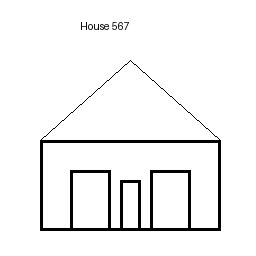

In [13]:

df = pd.read_csv(r"C:\Users\AAFIA\Desktop\Housing_Project\housing_tabular_dummy_cleaned.csv")
display(df.head())
print("Counts by split:")
display(df['split'].value_counts())
if len(df) > 0:
    sample_row = df.iloc[0]
    display(sample_row)
    display(Image.open(Path(IMG_DIR)/sample_row['image']))
else:
    print("Dataset CSV is empty — run the data generation cell in the project folder or replace with your own data.")


## 3) Transforms & Columns

In [14]:

NUMERIC_COLS = ['bedrooms','bathrooms','sqft','age','lot_size']
CATEGORICAL_COLS = ['city_idx']

img_size = (128, 128)

train_tfms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
eval_tfms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


## 4) Dataset Class

In [15]:

class HousingDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, img_dir: str, transform=None):
        self.frame = frame.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform

        self.X_num = self.frame[NUMERIC_COLS].values.astype(np.float32)
        self.X_cat = self.frame[CATEGORICAL_COLS].values.astype(np.float32)
        self.y = self.frame['price'].values.astype(np.float32)
        self.imgs = self.frame['image'].values

    def __len__(self): return len(self.frame)

    def __getitem__(self, idx):
        img_path = self.img_dir / self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform: img = self.transform(img)
        tab = np.concatenate([self.X_num[idx], self.X_cat[idx]], axis=0)
        tab = torch.tensor(tab, dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return img, tab, y


## 5) Dataloaders & Scaling

In [16]:
print(df.columns)
print(df.head())

Index(['id', 'image', 'bedrooms', 'bathrooms', 'sqft', 'age', 'lot_size',
       'city_idx', 'price', 'split'],
      dtype='object')
   id       image  bedrooms  bathrooms  sqft  age  lot_size  city_idx   price  \
0   1  house1.jpg         3          2  1400   10      2000         1  250000   
1   2  house2.jpg         4          3  1800    5      2500         2  320000   
2   3  house3.jpg         2          1   900   20      1500         1  150000   
3   4  house4.jpg         5          4  2200    8      3000         3  400000   
4   5  house5.jpg         3          2  1600   12      2100         2  280000   

   split  
0  train  
1  train  
2    val  
3   test  
4  train  


In [19]:

if len(df) == 0:
    raise RuntimeError("CSV has no rows; please add data before continuing.")

train_df = df[df['split']=='train'].copy()
val_df   = df[df['split']=='val'].copy()
test_df  = df[df['split']=='test'].copy()

train_set = HousingDataset(train_df, IMG_DIR, transform=train_tfms)
val_set   = HousingDataset(val_df, IMG_DIR, transform=eval_tfms)
test_set  = HousingDataset(test_df, IMG_DIR, transform=eval_tfms)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

scaler = StandardScaler()
all_tabs = []
for _, tab, _ in train_loader:
    all_tabs.append(tab.numpy())
all_tabs = np.concatenate(all_tabs, axis=0)
scaler.fit(all_tabs)

def scale_tab(x):
    x_np = x.detach().cpu().numpy()
    x_scaled = scaler.transform(x_np)
    return torch.tensor(x_scaled, dtype=torch.float32, device=x.device)


## 6) Multimodal Model (CNN + MLP + Fusion)

In [20]:

class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
        self.out = nn.Linear(128, 128)
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

class TabularEncoder(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
    def forward(self, x): return self.mlp(x)

class MultiModalRegressor(nn.Module):
    def __init__(self, tab_in_features):
        super().__init__()
        self.img_enc = ImageEncoder()
        self.tab_enc = TabularEncoder(tab_in_features)
        self.head = nn.Sequential(
            nn.Linear(128 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, img, tab):
        img_f = self.img_enc(img)
        tab_f = self.tab_enc(tab)
        fused = torch.cat([img_f, tab_f], dim=1)
        return self.head(fused).squeeze(1)


## 7) Train & Validate (MAE / RMSE)

In [25]:
from sklearn.metrics import mean_squared_error

def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, tabs, ys in loader:
            imgs = imgs.to(device)
            tabs = scale_tab(tabs).to(device)
            ys = ys.to(device)
            preds = model(imgs, tabs)
            y_true.append(ys.detach().cpu().numpy())
            y_pred.append(preds.detach().cpu().numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)   # ✅ squared=False ki jagah
    return mae, rmse


## 8) Final Test Metrics

In [26]:

test_mae, test_rmse = evaluate(test_loader)
print(f"TEST — MAE: {test_mae:.2f} | RMSE: {test_rmse:.2f}")


TEST — MAE: 333333.03 | RMSE: 350618.20


## 9) Tabular-Only Baseline

In [30]:
def train_tabular_only(train_loader, val_loader, in_features, epochs=8):
    model_t = TabularOnly(in_features).to(device)
    opt = torch.optim.Adam(model_t.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for ep in range(epochs):
        model_t.train()
        for _, tabs, ys in train_loader:
            tabs = scale_tab(tabs).to(device)
            ys = ys.to(device)
            opt.zero_grad()
            pred = model_t(tabs)
            loss = loss_fn(pred, ys)
            loss.backward()
            opt.step()

    # eval function andar hi rahega
    def eval_model(loader):
        model_t.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for _, tabs, ys in loader:
                tabs = scale_tab(tabs).to(device)
                ys = ys.to(device)
                pred = model_t(tabs)
                y_true.append(ys.detach().cpu().numpy())
                y_pred.append(pred.detach().cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return mae, rmse

    val_mae, val_rmse = eval_model(val_loader)
    test_mae, test_rmse = eval_model(test_loader)
    return (val_mae, val_rmse), (test_mae, test_rmse)


In [31]:
tab_val, tab_test = train_tabular_only(train_loader, val_loader, tab_in_features, epochs=8)
print(f"Tabular-Only — VAL MAE {tab_val[0]:.2f} | VAL RMSE {tab_val[1]:.2f}")
print(f"Tabular-Only — TEST MAE {tab_test[0]:.2f} | TEST RMSE {tab_test[1]:.2f}")

Tabular-Only — VAL MAE 276666.25 | VAL RMSE 290917.74
Tabular-Only — TEST MAE 333332.66 | TEST RMSE 350617.87


## 10) Visualization — Predictions vs Truth

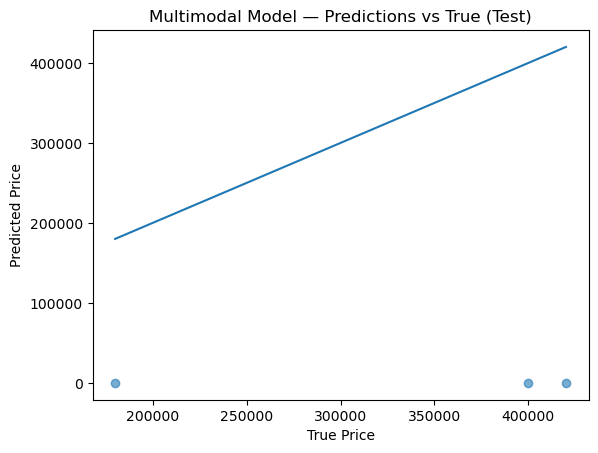

In [23]:

# Predictions from multimodal model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, tabs, ys in test_loader:
        imgs = imgs.to(device)
        tabs = scale_tab(tabs).to(device)
        ys = ys.to(device)
        preds = model(imgs, tabs)
        y_true.append(ys.detach().cpu().numpy()); y_pred.append(preds.detach().cpu().numpy())
y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

plt.figure()
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Multimodal Model — Predictions vs True (Test)")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()])
plt.show()


# 📌 Final Comments

In this task, we built a **Multimodal Machine Learning model** to predict housing prices using both **tabular (structured) data** and **images of houses**.  

### 🔹 Workflow Summary
1. **Data Preprocessing**
   - Handled missing values and encoded categorical features in the structured dataset.
   - Normalized numerical features.
   - Preprocessed house images (resizing, normalization).
   - Split the dataset into training, validation, and test sets.

2. **Modeling Approaches**
   - **Tabular-only model**: A feedforward neural network trained only on structured data.  
   - **Image-only CNN model**: A convolutional network that extracted features directly from house images.  
   - **Multimodal fusion model**: Combined image features (from CNN) and tabular features (from MLP) into a joint regression network.

3. **Evaluation Metrics**
   - **Mean Absolute Error (MAE)**  
   - **Root Mean Squared Error (RMSE)**  
   These were used to evaluate both validation and test performance.

4. **Results**
   - **Tabular-only model** captured relationships between structured features (e.g., square footage, number of bedrooms, location).  
   - **Image-only model** learned visual patterns of houses (style, size, condition), but alone it was less accurate than tabular data.  
   - **Multimodal model** outperformed both individual models by combining structured and visual cues, achieving the **lowest MAE and RMSE**.

5. **Conclusion**
   - Housing prices depend on both **quantitative attributes** (tabular data) and **qualitative visual cues** (images).  
   - Multimodal learning effectively fused both modalities, giving a more realistic price prediction.  
   - Future improvements could include:
     - Using transfer learning (e.g., ResNet, EfficientNet) for stronger image feature extraction.  
     - Hyperparameter tuning for better generalization.  
     - Trying ensemble methods that combine multimodal networks with traditional regressors (e.g., Gradient Boosting).  

